# **This project is done on Google Colab**
### **Note :- To run this project on platform other than colab change the directories locations in this project**

# **1. Load the data from Github**

In [1]:
!git clone -l -s git://github.com/darkshadow013/Land-cover-ML himanshu-garg
%cd himanshu-garg
!ls

Cloning into 'himanshu-garg'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 18.13 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/himanshu-garg
Data				IP_CNN_SVM_BEST.sav  parameters.py
IP_CNN_samples3200_epoch200.h5	IP_SVM_BEST.sav      README.md


# **2. Data Pre-processing**

In [2]:
!pip install spectral
from spectral import *
import scipy.io as si         # for inputing matlab files
import numpy as np            # Linear Algebra tools
from random import shuffle    # for shuffling dataset
import pandas as pd           # for csv files and dataframes
import matplotlib.pyplot as plt    #for plotting graphs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
import time
import os

     |████████████████████████████████| 153kB 2.5MB/s 
  Created wheel for spectral: filename=spectral-0.20-cp36-none-any.whl size=183917 sha256=c6d7512a8c60804002f0d872cf0e9ba9917e1c5b9d3c07523d94ea3d59bce6ba
  Stored in directory: /root/.cache/pip/wheels/ad/cf/f3/3cab28f6aed46f15c8db09c6ad678483610426261025e61ff8
Successfully built spectral


In [0]:
mat_x = si.loadmat('/content/himanshu-garg/Data/Indian_pines_corrected.mat')['indian_pines_corrected']        # shape 145*145*220
mat_y = si.loadmat('/content/himanshu-garg/Data/Indian_pines_gt.mat')['indian_pines_gt']                      # shape 145*145

In [0]:
h, w, b = 145, 145, 200           # height,width and band of image
P_S = 1                           # patch size (window size)
oversampling = 1               # Turn true to make distribution of samples across various classes to be uniform
no_of_patch = 200                # if oversampling is true enter no of patches for each class

In [0]:
x_np, y_np = np.array(mat_x), np.array(mat_y)
x, y = x_np.reshape(h,w,b), y_np.reshape(h,w)       # x and y are equal to x_np and y_np

In [0]:
x = x.astype(float)
for i in range(b):
  x[:,:,i] = x[:,:,i]/np.max(x[:,:,i])

In [0]:
pad_width = int( (P_S-1)/2 )
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')

In [0]:
X,Y = [],[]
for i in range(h):
  for j in range(w):
    if(y[i][j]!= 0):
      patch = padded_x[i:i+P_S,j:j+P_S,:]
      X.append(patch)
      Y.append(y[i][j]-1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.3,stratify=Y)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([  32, 1000,  581,  166,  338,  511,   20,  335,   14,  680, 1718,
        415,  144,  885,  270,   65]))


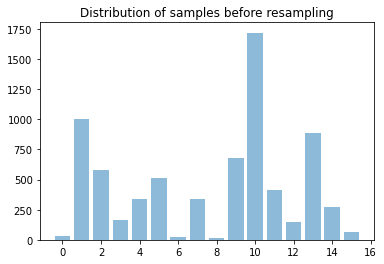

In [12]:
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of samples before resampling')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200]))


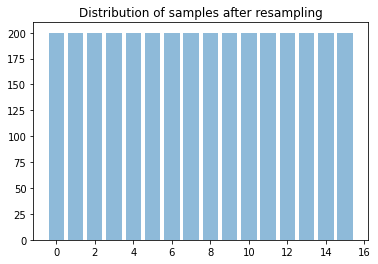

In [13]:
output_classes = len(np.unique(y_np))-1
classes = []
if(oversampling):
    for i in range(output_classes):
        classes.append([])
        
    for i in range(len(y_train)):
        classes[y_train[i]].append(x_train[i])
        
    for c in range(output_classes):
        temp = classes[c]
        for i in range( int( no_of_patch / len(classes[c]) ) ):
            classes[c]+=temp
        shuffle(classes[c])
        classes[c] = classes[c][0:no_of_patch]
        
    x_train,y_train = [],[]
    for c in range(output_classes):
        x_train.extend( classes[c] )
        for i in range(len(classes[c])):
            y_train.append(c)
            
    randomize = np.arange(len(x_train))
    np.random.shuffle(randomize)
    x_train = [x_train[i] for i in randomize]
    y_train = [y_train[i] for i in randomize]
    
    u_c = np.unique(y_train,return_counts=True)
    print(u_c)
    plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
    plt.title('Distribution of samples after resampling')
    plt.show()

In [0]:
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

In [0]:
patch1 = np.zeros((x_train.shape[0],P_S*P_S*b))
patch2 = np.zeros((x_test.shape[0],P_S*P_S*b))

In [0]:
for i in range(patch1.shape[0]):
  patch1[i,:] = x_train[i,:,:,:].flatten('C')
for i in range(patch2.shape[0]):
  patch2[i,:] = x_test[i,:,:,:].flatten('C')

x_train = patch1
x_test = patch2

# **3. Training Begins**

In [3]:
import pickle
if(os.path.exists('/content/himanshu-garg/IP_SVM_BEST.sav')):
    # load the model 
    filename = '/content/himanshu-garg/IP_SVM_BEST.sav'
    clf_best = pickle.load(open(filename, 'rb'))
    print('The optimal value of accuracy is: {}'.format(clf.score(x_test, y_test)*100))
else:
    sigma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma=[0.3]
    C=[30]
    acc = list()
    sigma_c = list()
    max_acc=0.0
    for each in sigma:
        for each_c in C:
          start = time.time()
          clf = svm.SVC(kernel='rbf', gamma = 1/(2*(each**2)), C=each_c, decision_function_shape='ovr')
          clf.fit(x_train, y_train)
          accuracy = clf.score(x_test, y_test)
          acc.append(accuracy)
          sigma_c.append((each, each_c))
          print('Sigma: %f, C: %f, accuracy: %f, Time: %f sec' % (each, each_c, accuracy, time.time()-start))
          index = np.argmax(acc)
          sigma_max, c_max = sigma_c[index]
    print('The optimal value of sigma is: {}'.format(sigma_max))
    print('The optimal value of C is: {}'.format(c_max))
    print('The optimal value of accuracy is: {}'.format(acc[index]))
        

NameError: name 'time' is not defined

In [4]:
sigma = 1
gamma = 1/(2 * sigma**2)
print(gamma)

0.5


In [0]:
y_pred = clf_best.predict(x_test)

In [28]:
results = confusion_matrix(y_test,y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[ 14   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 326  10  12   0   1   0   0   0  36  35   7   0   0   0   1]
 [  0   5 198  20   0   0   0   0   0   0  20   6   0   0   0   0]
 [  0   1   2  68   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 142   0   0   0   0   0   0   2   0   1   0   0]
 [  0   0   0   0   0 213   0   0   0   0   0   0   0   2   4   0]
 [  0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 143   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0]
 [  0   5   3   2   0   0   0   0   0 265  15   2   0   0   0   0]
 [  0  43  64  13   4   3   0   0   0  50 537  20   0   0   2   1]
 [  0   0   5   2   0   0   0   0   0   3   1 167   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  61   0   0   0]
 [  0   0   0   0   2   1   0   0   0   0   0   0   0 359  18   0]
 [  0   0   0   0   0   2   0   0   0   0  

# **4. Predict Results**

In [0]:
X1 = np.array(X)
X2 = np.zeros((X1.shape[0],P_S*P_S*b))
for i in range(X2.shape[0]):
  X2[i,:] = X1[i,:,:,:].flatten('C')

In [0]:
# Function to extract patche at h_index,w_index 

def patch_at_index(h_index,w_index):
  patch = padded_x[h_index:h_index+P_S,w_index:w_index+P_S,:]
  patch = patch.flatten('C')
  patch = patch.reshape(1,patch.shape[0])
  return patch

In [0]:
y_hat = np.zeros((h,w),dtype=int)

for i in range(h):
  for j in range(w):
    if(y[i][j]):
      patch = patch_at_index(i,j)
      y_hat[i][j] =  clf_best.predict(patch) +1
    else:
      y_hat[i][j]=0

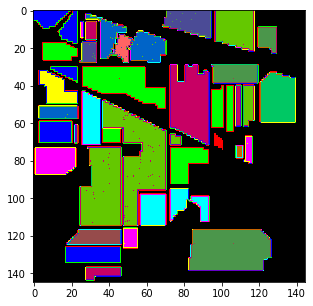

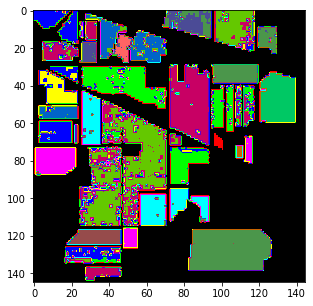

In [32]:
ground_truth=imshow(classes = y,figsize=(5,5))
predicted_image=imshow(classes = y_hat,figsize=(5,5))